In [277]:
import duckdb as dd
from pathlib import Path
import matplotlib.pyplot as plt

### Staging Tabelle

In [278]:
connect = dd.connect("data\\warehouse.duckdb")

In [279]:
connect.execute(
    "CREATE OR REPLACE TABLE staging_data AS " \
    "SELECT * FROM read_csv_auto('data\\example.csv')")

In [127]:
connect.sql("select * from staging_data limit 5")

┌─────────────────────┬─────────────┬────────────┬───────────┬─────────┬────────────┬───────────────┬───────────────────┬────────────────────┬────────┬────────────────┬──────────────┬───────────────────────┐
│    Purchase date    │ Customer ID │ First_Name │ Last_Name │ Gender  │  Birthday  │ Support Level │       City        │    Servicename     │ Costs  │ payment_method │ Sales Canal  │ Customer Satisfaction │
│      timestamp      │    int64    │  varchar   │  varchar  │ varchar │    date    │    varchar    │      varchar      │      varchar       │ double │    varchar     │   varchar    │         int64         │
├─────────────────────┼─────────────┼────────────┼───────────┼─────────┼────────────┼───────────────┼───────────────────┼────────────────────┼────────┼────────────────┼──────────────┼───────────────────────┤
│ 2024-06-06 19:13:54 │  4152186239 │ Nicholas   │ Avila     │ M       │ 1992-05-30 │ Premium       │ North Danielton   │ Custom Development │ 199.99 │ PayPal         │

In [128]:
connect.sql("describe select * from staging_data limit 5")

┌───────────────────────┬─────────────┬─────────┬─────────┬─────────┬─────────┐
│      column_name      │ column_type │  null   │   key   │ default │  extra  │
│        varchar        │   varchar   │ varchar │ varchar │ varchar │ varchar │
├───────────────────────┼─────────────┼─────────┼─────────┼─────────┼─────────┤
│ Purchase date         │ TIMESTAMP   │ YES     │ NULL    │ NULL    │ NULL    │
│ Customer ID           │ BIGINT      │ YES     │ NULL    │ NULL    │ NULL    │
│ First_Name            │ VARCHAR     │ YES     │ NULL    │ NULL    │ NULL    │
│ Last_Name             │ VARCHAR     │ YES     │ NULL    │ NULL    │ NULL    │
│ Gender                │ VARCHAR     │ YES     │ NULL    │ NULL    │ NULL    │
│ Birthday              │ DATE        │ YES     │ NULL    │ NULL    │ NULL    │
│ Support Level         │ VARCHAR     │ YES     │ NULL    │ NULL    │ NULL    │
│ City                  │ VARCHAR     │ YES     │ NULL    │ NULL    │ NULL    │
│ Servicename           │ VARCHAR     │ 

### Erste kleine Analysen
Es geht um das Kennenlernen der Daten. Die Abfragen beantworten erste Annahmen. 

In [149]:
# Wie viele unterschiedliche Kunden gibt es?
query = """
SELECT 
  count(DISTINCT "Customer ID") as Anzahl
FROM staging_data  
"""
connect.sql(query)

┌────────┐
│ Anzahl │
│ int64  │
├────────┤
│    100 │
└────────┘

In [130]:
# Wie oft kommen die 7 Services vor?
query = """
SELECT
  Servicename,
  count(Servicename) as Anzahl
FROM staging_data
GROUP BY Servicename
ORDER BY Anzahl DESC
"""
connect.sql(query)

┌────────────────────┬────────┐
│    Servicename     │ Anzahl │
│      varchar       │ int64  │
├────────────────────┼────────┤
│ Hardware           │  14409 │
│ Custom Development │  14309 │
│ Streaming          │  14306 │
│ Automation         │  14299 │
│ E-Commerce         │  14237 │
│ Databases          │  14225 │
│ Bi Tooling         │  14215 │
└────────────────────┴────────┘

In [150]:
# Welche Services haben wir?
# einmalige Services und ihre Kosten. ROW_Number() nummeriert durch
query = """
WITH cte AS (
SELECT DISTINCT
  Servicename,
  Costs
FROM staging_data
GROUP BY Servicename, Costs
ORDER BY Costs)
SELECT 
  ROW_NUMBER() OVER () AS ID,
  Servicename, 
  Costs
FROM CTE
"""
connect.sql(query)

┌───────┬────────────────────┬────────┐
│  ID   │    Servicename     │ Costs  │
│ int64 │      varchar       │ double │
├───────┼────────────────────┼────────┤
│     1 │ Bi Tooling         │   8.99 │
│     2 │ Databases          │   9.99 │
│     3 │ Hardware           │  12.69 │
│     4 │ Streaming          │  19.99 │
│     5 │ E-Commerce         │  39.99 │
│     6 │ Automation         │  89.99 │
│     7 │ Custom Development │ 199.99 │
└───────┴────────────────────┴────────┘

In [174]:
# Die Abfrage macht nur Sinn wenn der Preis sich ändern würde. Das ist hier nicht der Fall
query = """
SELECT DISTINCT
  Servicename,
  AVG(Costs)
FROM staging_data
GROUP BY Costs, Servicename
ORDER BY Costs
"""
connect.sql(query)

┌────────────────────┬────────────────────┐
│    Servicename     │     avg(Costs)     │
│      varchar       │       double       │
├────────────────────┼────────────────────┤
│ Bi Tooling         │   8.99000000000221 │
│ Databases          │  9.990000000001386 │
│ Hardware           │ 12.690000000001808 │
│ Streaming          │ 19.989999999996005 │
│ E-Commerce         │  39.98999999999336 │
│ Automation         │  89.98999999999188 │
│ Custom Development │  199.9900000000534 │
└────────────────────┴────────────────────┘

In [197]:
# Anzahl der Verkäufe pro Jahr
query = """
SELECT 
  EXTRACT(YEAR FROM "Purchase date") AS Year,
  COUNT(*) as Verkäufe
FROM staging_data
GROUP BY Year
ORDER BY Year
"""
connect.sql(query)

┌───────┬──────────┐
│ Year  │ Verkäufe │
│ int64 │  int64   │
├───────┼──────────┤
│  2010 │     6333 │
│  2011 │     6308 │
│  2012 │     6285 │
│  2013 │     6269 │
│  2014 │     6398 │
│  2015 │     6193 │
│  2016 │     6347 │
│  2017 │     6324 │
│  2018 │     6330 │
│  2019 │     6332 │
│  2020 │     6405 │
│  2021 │     6248 │
│  2022 │     6252 │
│  2023 │     6285 │
│  2024 │     6342 │
│  2025 │     5349 │
├───────┴──────────┤
│     16 rows      │
└──────────────────┘

In [198]:
# Verteilung auf Monate
query = """
SELECT
  STRFTIME("Purchase date", '%Y-%m') AS Jahr_Monat,
  COUNT(*) as Verkäufe
FROM staging_data
GROUP BY Jahr_Monat
ORDER BY Verkäufe DESC
LIMIT 10
"""
connect.sql(query)

┌────────────┬──────────┐
│ Jahr_Monat │ Verkäufe │
│  varchar   │  int64   │
├────────────┼──────────┤
│ 2022-05    │      589 │
│ 2010-08    │      581 │
│ 2019-01    │      580 │
│ 2024-08    │      580 │
│ 2014-12    │      578 │
│ 2019-05    │      578 │
│ 2025-01    │      576 │
│ 2024-10    │      574 │
│ 2012-07    │      572 │
│ 2012-08    │      571 │
├────────────┴──────────┤
│ 10 rows     2 columns │
└───────────────────────┘

In [199]:
# Verteilung auf Wochen
query = """
SELECT
  STRFTIME("Purchase date", '%Y-%W') AS Jahr_Woche,
  COUNT(*) as Verkäufe
FROM staging_data
GROUP BY Jahr_Woche
ORDER BY Verkäufe DESC
LIMIT 10
"""
connect.sql(query)

┌────────────┬──────────┐
│ Jahr_Woche │ Verkäufe │
│  varchar   │  int64   │
├────────────┼──────────┤
│ 2018-35    │      151 │
│ 2019-19    │      149 │
│ 2014-50    │      148 │
│ 2022-19    │      147 │
│ 2022-33    │      147 │
│ 2014-37    │      146 │
│ 2016-49    │      146 │
│ 2016-12    │      146 │
│ 2016-08    │      145 │
│ 2011-40    │      144 │
├────────────┴──────────┤
│ 10 rows     2 columns │
└───────────────────────┘

### Dimensionstabellen erstellen

In [280]:
# Services
query = """
CREATE OR REPLACE TABLE tblServices AS
WITH cte AS (
SELECT DISTINCT
  Servicename,
  Costs
FROM staging_data
ORDER BY Costs)
SELECT 
  ROW_NUMBER() OVER () AS service_id,
  Servicename, 
  Costs
FROM CTE
"""
connect.sql(query)

In [281]:
# Customers
query = """
CREATE OR REPLACE TABLE tblCustomers AS
SELECT DISTINCT
  "Customer ID" as customer_id,
  First_Name,
  Last_Name,
  Gender,
  City,
  "Support Level" as support_level,
  Birthday,
  date_diff('year', Birthday, today()) as Age
FROM staging_data
ORDER BY Last_Name
"""
connect.sql(query)

In [282]:
connect.sql("select * from tblCustomers where customer_id = '3114143559'")

┌─────────────┬────────────┬───────────┬─────────┬───────────────────┬───────────────┬────────────┬───────┐
│ customer_id │ First_Name │ Last_Name │ Gender  │       City        │ support_level │  Birthday  │  Age  │
│    int64    │  varchar   │  varchar  │ varchar │      varchar      │    varchar    │    date    │ int64 │
├─────────────┼────────────┼───────────┼─────────┼───────────────────┼───────────────┼────────────┼───────┤
│  3114143559 │ Darryl     │ Gonzalez  │ F       │ North Christopher │ Premium       │ 1998-08-03 │    27 │
└─────────────┴────────────┴───────────┴─────────┴───────────────────┴───────────────┴────────────┴───────┘

In [283]:
query = """
CREATE OR REPLACE TABLE tblOrders AS
SELECT 
  ROW_NUMBER () OVER () as order_id,
  sd."Purchase date" as purchase_date,
  c.customer_id,
  s.service_id,
  sd.payment_method,
  sd."Sales Canal" as sales_canal,
  sd."Customer Satisfaction" as satisfaction
FROM 
  staging_data sd
JOIN tblCustomers c ON sd."Customer ID" = c.customer_id
JOIN tblServices s ON sd.Servicename = s.Servicename
"""
connect.sql(query)

### Tabellen überprüfen

In [284]:
connect.sql("select * from tblOrders limit 5")

┌──────────┬─────────────────────┬─────────────┬────────────┬────────────────┬──────────────┬──────────────┐
│ order_id │    purchase_date    │ customer_id │ service_id │ payment_method │ sales_canal  │ satisfaction │
│  int64   │      timestamp      │    int64    │   int64    │    varchar     │   varchar    │    int64     │
├──────────┼─────────────────────┼─────────────┼────────────┼────────────────┼──────────────┼──────────────┤
│        1 │ 2024-06-06 19:13:54 │  4152186239 │          7 │ PayPal         │ online       │            4 │
│        2 │ 2017-10-29 22:55:18 │  4455461458 │          4 │ SEPA           │ online       │            5 │
│        3 │ 2013-09-19 08:27:45 │  1886436889 │          4 │ SEPA           │ online       │            3 │
│        4 │ 2023-12-18 23:25:37 │  7274373746 │          2 │ PayPal         │ on site      │            1 │
│        5 │ 2018-12-23 12:39:22 │  3114143559 │          5 │ PayPal         │ by telephone │            2 │
└──────────┴───────

In [285]:
# Alle Daten wieder zusammensetzen. 
query = """
SELECT 
  purchase_date,
  first_name,
  last_name,
  gender,
  support_level,
  city,
  servicename,
  payment_method,
  satisfaction
FROM
  tblOrders o
JOIN tblCustomers c ON o.customer_id = c.customer_id
JOIN tblServices s ON s.service_id = o.service_id
LIMIT 10
"""
connect.sql(query)

┌─────────────────────┬────────────┬───────────┬─────────┬───────────────┬───────────────────┬────────────────────┬────────────────┬──────────────┐
│    purchase_date    │ First_Name │ Last_Name │ Gender  │ support_level │       City        │    Servicename     │ payment_method │ satisfaction │
│      timestamp      │  varchar   │  varchar  │ varchar │    varchar    │      varchar      │      varchar       │    varchar     │    int64     │
├─────────────────────┼────────────┼───────────┼─────────┼───────────────┼───────────────────┼────────────────────┼────────────────┼──────────────┤
│ 2024-06-06 19:13:54 │ Nicholas   │ Avila     │ M       │ Premium       │ North Danielton   │ Custom Development │ PayPal         │            4 │
│ 2017-10-29 22:55:18 │ Sarah      │ Willis    │ M       │ Premium       │ North Annfort     │ Streaming          │ SEPA           │            5 │
│ 2013-09-19 08:27:45 │ Earl       │ Smith     │ M       │ Premium       │ Brianmouth        │ Streaming        

In [286]:
connect.sql("SELECT COUNT(DISTINCT customer_id) FROM tblCustomers;")

┌─────────────────────────────┐
│ count(DISTINCT customer_id) │
│            int64            │
├─────────────────────────────┤
│                         100 │
└─────────────────────────────┘

In [287]:
connect.sql("SELECT COUNT(DISTINCT servicename) FROM tblServices;")

┌─────────────────────────────┐
│ count(DISTINCT servicename) │
│            int64            │
├─────────────────────────────┤
│                           7 │
└─────────────────────────────┘

In [288]:
# haben wir Customer doppelt in der tblCustomers?
query = """
  SELECT
    customer_id,
    COUNT(*) as counter
  FROM tblCustomers c
  GROUP BY c.customer_id
  HAVING counter > 1
"""
connect.sql(query)

┌─────────────┬─────────┐
│ customer_id │ counter │
│    int64    │  int64  │
├─────────────┴─────────┤
│        0 rows         │
└───────────────────────┘

In [289]:
connect.sql("SELECT COUNT(DISTINCT customer_id) FROM tblCustomers;")


┌─────────────────────────────┐
│ count(DISTINCT customer_id) │
│            int64            │
├─────────────────────────────┤
│                         100 │
└─────────────────────────────┘

In [290]:
connect.sql("SELECT COUNT(DISTINCT service_id) FROM tblServices;")

┌────────────────────────────┐
│ count(DISTINCT service_id) │
│           int64            │
├────────────────────────────┤
│                          7 │
└────────────────────────────┘

In [291]:
connect.sql("SELECT COUNT(DISTINCT order_id) FROM tblOrders;")

┌──────────────────────────┐
│ count(DISTINCT order_id) │
│          int64           │
├──────────────────────────┤
│                   100000 │
└──────────────────────────┘

### Analyse
Hier werden die Daten ausgewertet. 

In [292]:
# Wie viele Bestellungen gibt es insgesamt?
query = """
SELECT 
  COUNT(*) as total_orders
FROM tblOrders
"""
connect.sql(query)

┌──────────────┐
│ total_orders │
│    int64     │
├──────────────┤
│       100000 │
└──────────────┘

In [269]:
# Welches Jahr war das Umsatzstärkste?
query = """
SELECT 
  SUM(s.costs) as in_total,
  count(o.purchase_date) as in_total_orders,
  extract('year' FROM o.purchase_date) as year
FROM 
  tblOrders o
JOIN tblServices s ON o.service_id = s.service_id
GROUP BY year
ORDER BY in_total desc
"""
connect.sql(query)


┌────────────────────┬─────────────────┬───────┐
│      in_total      │ in_total_orders │ year  │
│       double       │      int64      │ int64 │
├────────────────────┼─────────────────┼───────┤
│  360923.0399999735 │            6476 │  2020 │
│  358328.9999999741 │            6390 │  2010 │
│  355844.9899999735 │            6401 │  2018 │
│ 354580.43999997474 │            6406 │  2016 │
│  354038.7299999747 │            6347 │  2023 │
│ 351351.83999997395 │            6466 │  2014 │
│  347123.2799999748 │            6412 │  2024 │
│ 346831.78999997524 │            6261 │  2015 │
│  345516.5099999747 │            6309 │  2021 │
│ 344667.63999997603 │            6356 │  2012 │
│  344116.6899999748 │            6381 │  2019 │
│ 341506.53999997623 │            6316 │  2022 │
│ 340894.90999997465 │            6379 │  2011 │
│ 339555.29999997595 │            6320 │  2013 │
│ 338732.93999997544 │            6386 │  2017 │
│   289644.249999983 │            5395 │  2025 │
├───────────────────

### Das stärkste Jahr grafisch

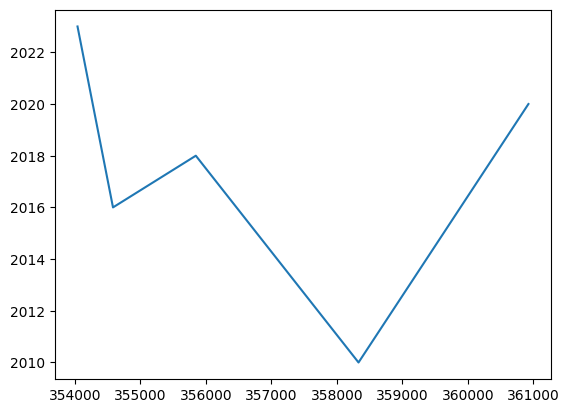

In [270]:
query = """
SELECT 
  SUM(s.costs) as in_total,
  extract('year' FROM o.purchase_date) as year
FROM 
  tblOrders o
JOIN tblServices s ON o.service_id = s.service_id
GROUP BY year
ORDER BY in_total desc
LIMIT 5
"""
df = connect.execute(query).df()
plt.plot(df['in_total'], df['year'])

In [271]:
# Welcher Service ist der beliebteste?
query = """
SELECT 
  count(s.service_id) as in_total,
  s.Servicename
FROM 
  tblOrders o
JOIN tblServices s ON o.service_id = s.service_id
GROUP BY o.service_id, s.Servicename
ORDER BY in_total desc
"""
connect.sql(query)

┌──────────┬────────────────────┐
│ in_total │    Servicename     │
│  int64   │      varchar       │
├──────────┼────────────────────┤
│    14567 │ Hardware           │
│    14473 │ Custom Development │
│    14432 │ Streaming          │
│    14423 │ Automation         │
│    14388 │ E-Commerce         │
│    14375 │ Databases          │
│    14343 │ Bi Tooling         │
└──────────┴────────────────────┘

### Der beliebteste Service grafisch

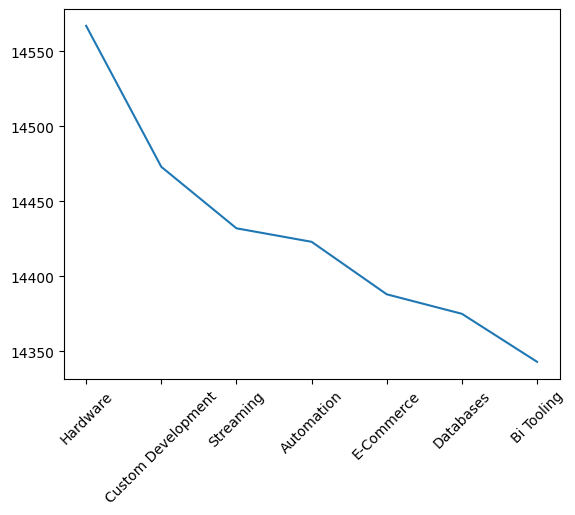

In [272]:
query = """
SELECT 
  count(s.service_id) as in_total,
  s.Servicename
FROM 
  tblOrders o
JOIN tblServices s ON o.service_id = s.service_id
GROUP BY o.service_id, s.Servicename
ORDER BY in_total desc
"""
df = connect.query(query).df()
plt.xticks(rotation=45)
plt.plot(df['Servicename'], df['in_total'])

In [273]:
# Welcher Service ist der Beliebteste aber mit Window Functions. 
query = """
SELECT DISTINCT
  s.Servicename
  ,COUNT() OVER (PARTITION BY s.Servicename) as Counter
FROM tblOrders o
JOIN tblServices s ON o.service_id = s.service_id
ORDER BY Counter desc
LIMIT 7
"""
connect.sql(query)

┌────────────────────┬─────────┐
│    Servicename     │ Counter │
│      varchar       │  int64  │
├────────────────────┼─────────┤
│ Hardware           │   14567 │
│ Custom Development │   14473 │
│ Streaming          │   14432 │
│ Automation         │   14423 │
│ E-Commerce         │   14388 │
│ Databases          │   14375 │
│ Bi Tooling         │   14343 │
└────────────────────┴─────────┘

### Kundenverhalten

In [294]:
# Wer sind die Top 5 Kunden?
query = """
SELECT
  customer_id,
  count(*) as order_count
FROM tblOrders
GROUP BY customer_id
ORDER BY order_count desc
LIMIT 5
"""
connect.sql(query)

┌─────────────┬─────────────┐
│ customer_id │ order_count │
│    int64    │    int64    │
├─────────────┼─────────────┤
│  3114143559 │        1001 │
│  2916415442 │        1000 │
│  1959581629 │        1000 │
│  1311855872 │        1000 │
│  4469455679 │        1000 │
└─────────────┴─────────────┘

In [296]:
connect.close()